In [90]:
import random
import torch
import os
import hashlib
import requests
import re
import collections
import matplotlib.pyplot as plt

## 学习语言模型

## 马尔可夫模型与n元语法

## 自然语言统计

In [91]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [92]:
def download_dataset(name, cache_dir=None):
    """下载一个DATA_HUB中的文件,返回本地文件名"""
    assert name in DATA_HUB, f"{name} not in {DATA_HUB}"
    cache_dir = os.path.join('..', 'data') if cache_dir is None else cache_dir
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
            if sha1.hexdigest() == sha1_hash:
                return fname
    print(f"Downloading {name} from {url} to {fname}...")
    raw_data = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(raw_data.content)
    return fname


In [93]:
DATA_HUB['time_machine'] = (DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

In [94]:
def read_time_machine():
    with open(download_dataset('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

In [95]:
def tokenize(lines, token='word'):
    match token:
        case 'word':
            return [line.split() for line in lines]
        case 'char':
            return [list(line) for line in lines]
        case _:
            print('错误: 未知词元类型: '+token)

In [96]:
class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        tokens = [] if tokens is None else tokens
        reserved_tokens = [] if reserved_tokens is None else reserved_tokens
        ## 按出现频率排序
        counter = Vocab.count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.idx2token = ['<unk>'] + reserved_tokens
        self.token2idx = {token: idx for idx, token in enumerate(self.idx2token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token2idx:
                self.idx2token.append(token)
                self.token2idx[token] = len(self.idx2token)-1
    def __len__(self):
        return len(self.idx2token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token2idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx2token[indices]
        return [self.idx2token[index] for index in indices]
    @property
    def unk(self):
        return 0
    @property
    def token_freqs(self):
        return self._token_freqs 
    @staticmethod
    def count_corpus(tokens):
        """统计词元频率"""
        if isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)
  

In [97]:
def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

In [98]:
tokens = tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

In [99]:
def set_axes(axes, xlabel, ylabel, xscale, yscale, xlim, ylim):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.grid()

def plot(xs, ys, xlabel, ylabel, xlim=None, ylim=None, xscale='linear', yscale='linear', legend=None, figsize=(6, 3)):
    plt.rcParams['figure.figsize'] =figsize
    set_axes(plt.gca(), xlabel, ylabel, xscale, yscale, xlim, ylim)
    try:
        len(xs[0])
    except:
        xs = [xs]*len(ys)
    for x, y in zip(xs, ys):
        plt.plot(x, y)
    plt.legend(legend if legend else [])

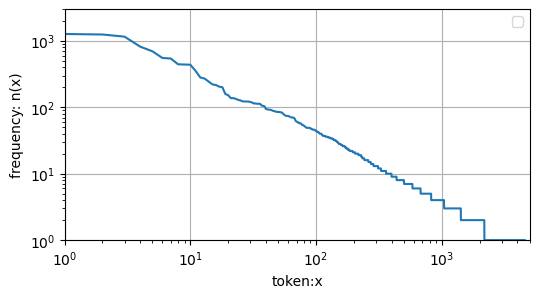

In [100]:
freqs = [freq for token, freq in vocab.token_freqs]
plot(range(len(freqs)), [freqs], xlabel='token:x', ylabel='frequency: n(x)', xscale='log', yscale='log', xlim=[1,5000], ylim=[1,3000])

In [101]:
bigram_tokens = list(zip(corpus[:-1], corpus[1:]))
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [102]:
trigram_tokens = list(zip(corpus[:-2], corpus[1:-1], corpus[2:]))
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

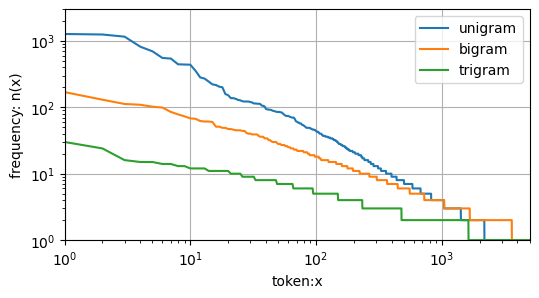

In [103]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
plot([list(range(len(freqs))), list(range(len(bigram_freqs))), list(range(len(trigram_freqs)))], 
     [freqs, bigram_freqs, trigram_freqs], 
     xlabel='token:x', ylabel='frequency: n(x)', 
     xscale='log', yscale='log', 
     legend=['unigram', 'bigram', 'trigram'],
     xlim=[1,5000], ylim=[1,3000])

## 获取长序列数据

In [104]:
## 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    corpus = corpus[random.randint(0, num_steps-1):]
    num_subseqs = (len(corpus)-1) // num_steps
    initial_indices = list(range(0, num_subseqs*num_steps, num_steps))
    random.shuffle(initial_indices)

    def data(pos):
        return corpus[pos:pos+num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size*num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j+1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [105]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X}\nY: {Y}')

X: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])
X: tensor([[ 4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13]])
Y: tensor([[ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14]])
X: tensor([[24, 25, 26, 27, 28],
        [19, 20, 21, 22, 23]])
Y: tensor([[25, 26, 27, 28, 29],
        [20, 21, 22, 23, 24]])


In [106]:
## 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus)-offset-1)//batch_size)*batch_size
    Xs = torch.tensor(corpus[offset:offset+num_tokens])
    Ys = torch.tensor(corpus[offset+1:offset+num_tokens+1])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps*num_batches, num_steps):
        X = Xs[:, i:i+num_steps]
        Y = Ys[:, i:i+num_steps]
        yield X, Y

In [107]:
my_seq = list(range(35))
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X}\nY: {Y}')

X: tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]])
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X: tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]])
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [108]:
class SeqDataLoader:
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        self.data_iter_fn = seq_data_iter_random if use_random_iter else seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)  
        self.batch_size, self.num_steps = batch_size, num_steps
    def  __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [109]:
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens
    )
    return data_iter, data_iter.vocab

## Exercises

1. 假设训练数据集中有$100,000$个单词。一个四元语法需要存储多少个词频和相邻多词频率？

2. 我们如何对一系列对话建模？

3. 一元语法、二元语法和三元语法的齐普夫定律的指数是不一样的，能设法估计么？

4. 想一想读取长序列数据的其他方法？

5. 考虑一下我们用于读取长序列的随机偏移量
   - 为什么随机偏移量是个好主意？
   - 它真的会在文档的序列上实现完美的均匀分布吗？
   - 要怎么做才能使分布更均匀？

6. 如果我们希望一个序列样本是一个完整的句子，那么这在小批量抽样中会带来怎样的问题？如何解决？